# MEG Data Preprocessing Pipeline - Subject 91

## Overview
This notebook implements a standardized preprocessing pipeline for OPM-MEG data analysis. The pipeline is designed for **subject sub-91** (healthy participant)
and processes one session at a time through a modular, reusable framework.

## Research Context
- **Subject**: sub-91 (healthy control participant)
- **Data Type**: OPM-MEG recordings (.fif format)

## 1- Preprocessing Steps


### 1.1- Libraries:

In [1]:
# ---- LIBRARIES ----
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
sys.path.append('../source')
from find_paths import get_onedrive_path
from plot_functions import (plot_channels_comparison,
                            plot_meg_2x3_grid,
                            plot_ica_components,
                            plot_all_channel_power_spectra)

from config_manager import (load_and_display_config,
                            validate_file_selection,
                            preprocess_meg_data,remove_ica_artifacts)

from MEG_analysis_functions import apply_fastica_to_channels


### 1.2- Load configuration:

In [2]:
# ---- LOAD CONFIGURATION ----
# Add source directory to path for custom functions
sys.path.append('../source')

# Define subject and version for this notebook:
SUBJECT_ID = "sub-91"
CONFIG_VERSION = "Version-1"

config = load_and_display_config(SUBJECT_ID, version=CONFIG_VERSION)

Configuration loaded for sub-91
SELECTABLE PARAMETERS:
DATA_TYPES: ['source_data', 'raw_data', 'processed_data']
SETUPS: ['setupA', 'setupB']
CONDITIONS:
  setupA: ['Move1', 'Move2', 'MoveMockDys', 'Rest', 'RestMockDys']
  setupB: ['Move', 'MoveMockDys', 'Rest', 'RestMockDys']


### 1.3- Path Setup:

In [3]:
# Get base data path

base_data_path = get_onedrive_path('data')
print("Base data path found successfully")
print(f"Base path: {base_data_path}")


project folder found: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG
Base data path found successfully
Base path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data


In [16]:
# ---- FILE SELECTION ----

print("\n" + "="*60)
print("USER SELECTION REQUIRED:")
print("Based on the available options above, define your selection:")

# USER DEFINES THESE PARAMETERS (the only place where selection happens)
DATA_TYPE = "raw_data"        # Choose from available DATA TYPES
SETUP = "setupA"              # Choose from available SETUPS  
CONDITION = "Rest"           # Choose from available CONDITIONS

print(f"\nSelected: {DATA_TYPE} -> {SETUP} -> {CONDITION}")

# Validate selection and construct path using config
filename, path_info = validate_file_selection(config, DATA_TYPE, SETUP, CONDITION)

# Construct complete file path using ALL config parameters
file_path = os.path.join(
    base_data_path,
    path_info['base_folder'],
    config['subject_id'],
    path_info['subfolder'],
    filename
)

print(f"Selected file: {filename}")
print(f"Full file path: {file_path}")
print(f"File exists: {os.path.exists(file_path)}")


USER SELECTION REQUIRED:
Based on the available options above, define your selection:

Selected: raw_data -> setupA -> Rest
Selected file: sub-91_OPM-MEG_setupA_Rest_raw.fif
Full file path: /Users/federicobonato/OneDrive - Charité - Universitätsmedizin Berlin/TRR295 via Teams - LID_MEG - LID_MEG/data/raw_data/sub-91/OPM_MEG/sub-91_OPM-MEG_setupA_Rest_raw.fif
File exists: True


In [5]:
# ---- LOAD AND EXPLORE DATA ----

# Load the MEG data
print(f"Loading file: {filename}")
raw = mne.io.read_raw_fif(file_path, preload=True, verbose=False)

print(f"\nData loaded successfully for {config['subject_id']}")
print("="*50)
print("DATA EXPLORATION:")
print("="*50)

# Basic data information
data_shape = raw.get_data().shape
print(f"Data shape: {data_shape}")
print(f"Number of channels: {raw.info['nchan']}")
print(f"Number of time points: {len(raw.times)}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.2f} seconds")


Loading file: sub-91_OPM-MEG_setupA_Rest_raw.fif

Data loaded successfully for sub-91
DATA EXPLORATION:
Data shape: (161, 595893)
Number of channels: 161
Number of time points: 595893
Sampling frequency: 2000.0 Hz
Duration: 297.95 seconds


### Data Summary

**Recording Information:**
- **Number of time points:** 390,288
- **Sampling frequency:** 2,000.0 Hz  
- **Duration:** 195.14 seconds (~3.25 minutes)

**Channel Configuration:**
- **Usable MEG channels:** 001 to 007 (7 channels total)


In [6]:
# ---- MEG CHANNELS ANALYSIS ----

# Get MEG channel mapping from config
meg_channel_map = config['meg_channels']

print(f"\nMEG CHANNELS MAPPING:")
print("="*30)
print(f"Total MEG channels: {len(meg_channel_map)}")
print("Channel mapping:")

for brain_region, meg_channel in meg_channel_map.items():
    print(f"  {brain_region} -> {meg_channel}")




MEG CHANNELS MAPPING:
Total MEG channels: 7
Channel mapping:
  C3 -> MEG 001
  C4 -> MEG 002
  CZ -> MEG 003
  F3 -> MEG 004
  F4 -> MEG 005
  P3 -> MEG 006
  P4 -> MEG 007


## 2- Preprocessing Pipeline

The following preprocessing steps will be applied to the MEG data to prepare it for analysis:

**Configuration Parameters:**
- Target sampling frequency: 512 Hz
- Bandpass filter: 1-100 Hz  
- Notch filter frequencies: 50, 100, 150 Hz

In [7]:
# ---- PREPROCESSING CONFIGURATION ----
print("\n" + "="*50)
print("PREPROCESSING CONFIGURATION:")
print("="*50)

# ---- DEFINE PREPROCESSING PARAMETERS AS CONSTANTS ----

TESLA_TO_PICOTESLA = 1e12
TARGET_SFREQ = 512  # Target sampling frequency (Hz)
BANDPASS_LOW = 1    # Low frequency cutoff (Hz)
BANDPASS_HIGH = 100 # High frequency cutoff (Hz)
NOTCH_FREQS = [50, 100, 150]  # Line noise frequencies to remove (Hz)
MEG_SFREQ = raw.info['sfreq']  # Current sampling frequency
HFC_ORDER = 1  # Order of high-frequency components to remove

print(f"Conversion factor: {TESLA_TO_PICOTESLA:.0e}")
print(f"Current sampling frequency: {MEG_SFREQ} Hz")
print(f"Target sampling frequency: {TARGET_SFREQ} Hz")
print(f"Bandpass filter: {BANDPASS_LOW}-{BANDPASS_HIGH} Hz")
print(f"Notch filter frequencies: {NOTCH_FREQS} Hz")




PREPROCESSING CONFIGURATION:
Conversion factor: 1e+12
Current sampling frequency: 2000.0 Hz
Target sampling frequency: 512 Hz
Bandpass filter: 1-100 Hz
Notch filter frequencies: [50, 100, 150] Hz


In [8]:
# ---- PREPROCESSING PIPELINE ----

# Convert data from Tesla to picoTesla (multiply by 1e12)
raw_data = raw.get_data()
raw_data_pT = raw_data * TESLA_TO_PICOTESLA
raw._data = raw_data_pT


# Apply complete preprocessing pipeline using configurable parameters
raw_preprocessed = preprocess_meg_data(
    raw=raw,
    start_sfreq=MEG_SFREQ,
    target_sfreq=TARGET_SFREQ,
    l_freq=BANDPASS_LOW,
    h_freq=BANDPASS_HIGH,
    notch_freqs=NOTCH_FREQS,
    hfc_components=HFC_ORDER,
    verbose=True
)

# Store the result for further analysis
raw_filtered = raw_preprocessed


STEP 1: DOWNSAMPLING
Downsampled from 2000.0 Hz to 512 Hz

STEP 2: HOMOGENEOUS FIELD CORRECTION (HFC)
3 projection items deactivated
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
Applied HFC with 3 components

STEP 3: FILTERING (LINE NOISE REMOVAL)
Applied bandpass filter: 1-100 Hz
Applied notch filters at: [50, 100, 150] Hz


### 2.1- Compare raw vs filtered:

- **First plot on the entire time series**
- **Second one on a shorter time window**

In [9]:
# ---- SETTING UP PLOTTING PARAMETERS ----

# Use first 7 MEG channels directly
NUM_MEG_CHANNELS = len(config['meg_channels'])
MEG_CHANNEL_INDICES = list(range(NUM_MEG_CHANNELS))
MEG_CHANNEL_NAMES = [raw.ch_names[i] for i in MEG_CHANNEL_INDICES]

print(f"Using {NUM_MEG_CHANNELS} MEG channels: {MEG_CHANNEL_NAMES}")

# Get channel data
raw_meg_channels = [raw.get_data()[idx] for idx in MEG_CHANNEL_INDICES]
preprocessed_meg_channels = [raw_filtered.get_data()[idx] for idx in MEG_CHANNEL_INDICES]
RAW_TIME = raw.times
PREPROCESSED_TIME = raw_filtered.times
COLORS = plt.cm.Set1(np.linspace(0, 1, NUM_MEG_CHANNELS))


Using 7 MEG channels: ['MEG 001', 'MEG 002', 'MEG 003', 'MEG 004', 'MEG 005', 'MEG 006', 'MEG 007']



MEG CHANNELS COMPARISON: RAW vs PREPROCESSED


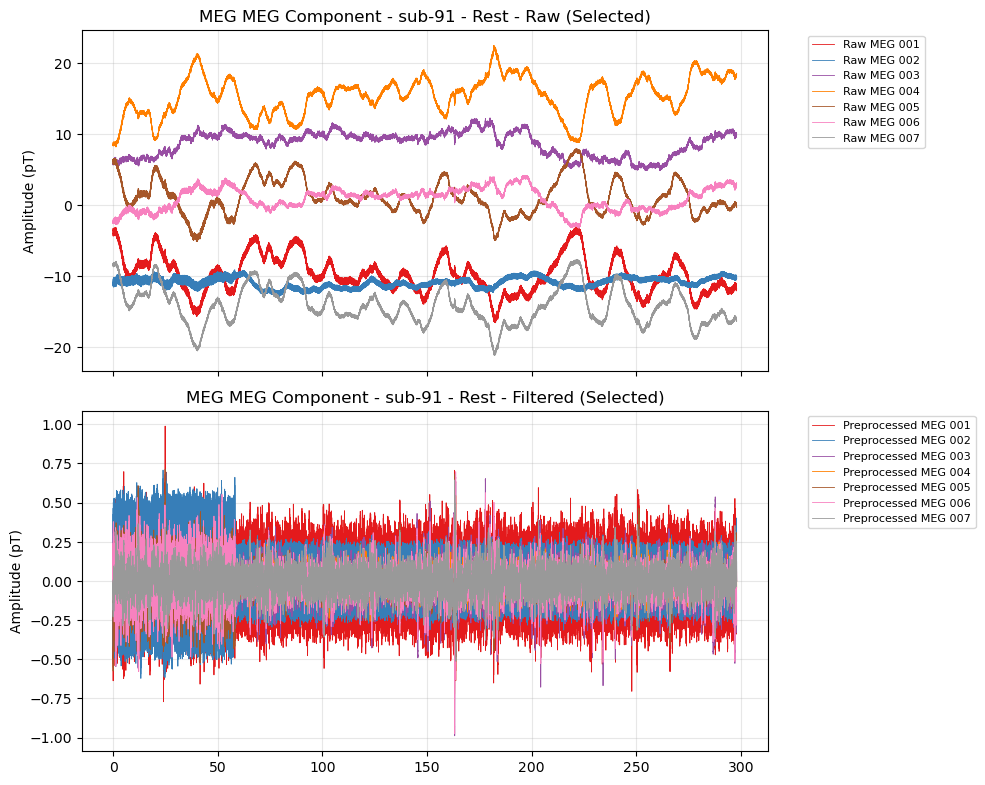

In [10]:
# ---- VISUALIZE RAW VS PREPROCESSED COMPARISON ----
print("\n" + "="*60)
print("MEG CHANNELS COMPARISON: RAW vs PREPROCESSED")
print("="*60)

plot_channels_comparison(
    time_0=RAW_TIME,
    time_1=PREPROCESSED_TIME,
    raw_channels=raw_meg_channels,
    filtered_channels=preprocessed_meg_channels,
    raw_labels=[f"Raw {name}" for name in MEG_CHANNEL_NAMES],
    filtered_labels=[f"Preprocessed {name}" for name in MEG_CHANNEL_NAMES],
    colors=plt.cm.Set1(np.linspace(0, 1, NUM_MEG_CHANNELS)),
    rec_label=f"{SUBJECT_ID} - {CONDITION}",
    y_label="Amplitude (pT)",
    axis_label="MEG",
    sync_ylim=False

)


MEG CHANNELS DETAILED COMPARISON: 1-SECOND WINDOW


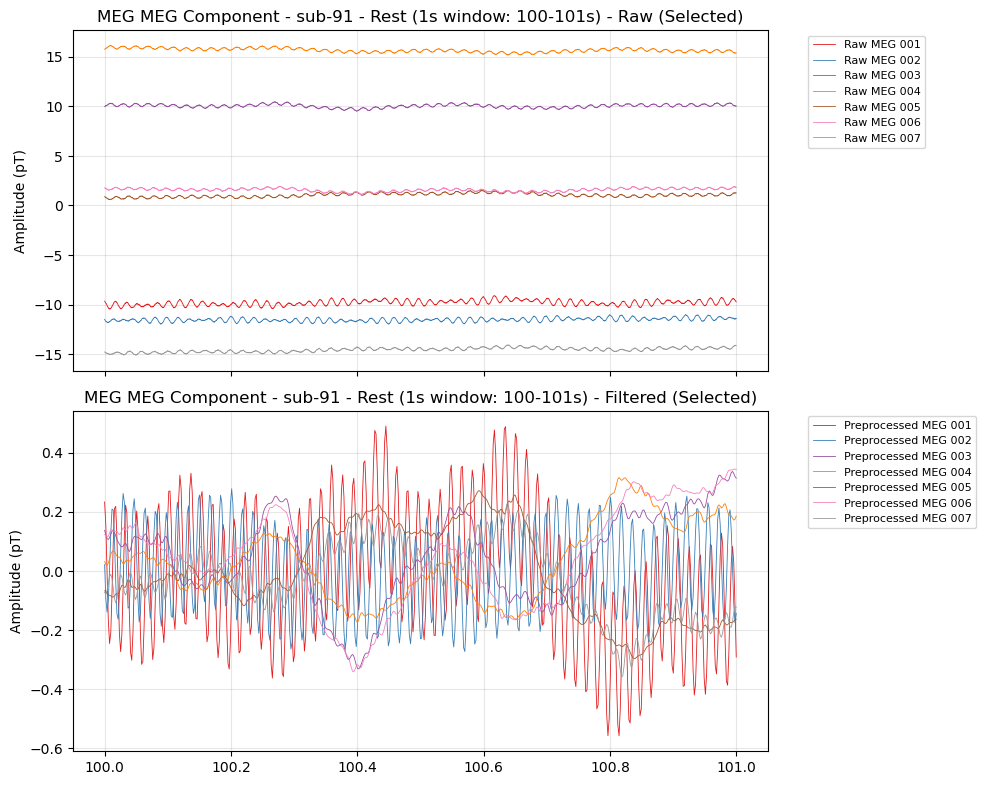

In [11]:

# Define time window parameters
WINDOW_DURATION = 1  # seconds
START_TIME = 100       # start time

# Create boolean masks for both raw and preprocessed data
raw_mask = (RAW_TIME >= START_TIME) & (RAW_TIME <= START_TIME + WINDOW_DURATION)
preprocessed_mask = (PREPROCESSED_TIME >= START_TIME) & (PREPROCESSED_TIME <= START_TIME + WINDOW_DURATION)

# Extract time windows
raw_time_window = RAW_TIME[raw_mask]
preprocessed_time_window = PREPROCESSED_TIME[preprocessed_mask]

# Extract channel data for the time window
raw_meg_channels_window = [channel[raw_mask] for channel in raw_meg_channels]
preprocessed_meg_channels_window = [channel[preprocessed_mask] for channel in preprocessed_meg_channels]

# ---- VISUALIZE DETAILED COMPARISON (30-SECOND WINDOW) ----
print("\n" + "="*60)
print(f"MEG CHANNELS DETAILED COMPARISON: {WINDOW_DURATION}-SECOND WINDOW")
print("="*60)

plot_channels_comparison(
    time_0=raw_time_window,
    time_1=preprocessed_time_window,
    raw_channels=raw_meg_channels_window,
    filtered_channels=preprocessed_meg_channels_window,
    raw_labels=[f"Raw {name}" for name in MEG_CHANNEL_NAMES],
    filtered_labels=[f"Preprocessed {name}" for name in MEG_CHANNEL_NAMES],
    colors=COLORS,
    rec_label=f"{SUBJECT_ID} - {CONDITION} ({WINDOW_DURATION}s window: {START_TIME}-{START_TIME + WINDOW_DURATION}s)",
    y_label="Amplitude (pT)",
    axis_label="MEG",
    sync_ylim=False
)


### 2.2- ICA analysis:

**ICA Configuration:**
- **Method**: FastICA algorithm
- **Components**: 7 (equal to number of MEG channels)
- **Input**: Preprocessed MEG data (512 Hz, filtered)

In [12]:
# ---- ICA ANALYSIS ON MEG CHANNELS ----
print("\n" + "="*60)
print("APPLYING ICA TO MEG CHANNELS")
print("="*60)

# Apply FastICA to the preprocessed MEG data
# Use the number of MEG channels as the number of components
N_ICA_COMPONENTS = NUM_MEG_CHANNELS  # 7 components
ICA_RANDOM_STATE = 0  # For reproducibility
ICA_MAX_ITER = 1000   # Maximum iterations for convergence

print(f"Applying FastICA with {N_ICA_COMPONENTS} components...")

# Get preprocessed MEG data for ICA (shape: n_channels, n_times)
# One array with all the channels
meg_data_for_ica = np.array(preprocessed_meg_channels)

# Apply FastICA:
ica_signals, ica_model = apply_fastica_to_channels(
    channels=meg_data_for_ica,
    n_components=N_ICA_COMPONENTS,
    random_state=ICA_RANDOM_STATE,
    max_iter=ICA_MAX_ITER
)

# Create component names for plotting
ICA_COMPONENT_NAMES = [f"ICA-{i+1}" for i in range(N_ICA_COMPONENTS)]
print(f"ICA component names: {ICA_COMPONENT_NAMES}")


APPLYING ICA TO MEG CHANNELS
Applying FastICA with 7 components...
ICA component names: ['ICA-1', 'ICA-2', 'ICA-3', 'ICA-4', 'ICA-5', 'ICA-6', 'ICA-7']


### 2.3- Visualise ICA components:

**Objective**: Even in this case the idea is to analyse the ICA components. Here it's possible to decide the time window's lenght in order to have a overall or a more detailed view.

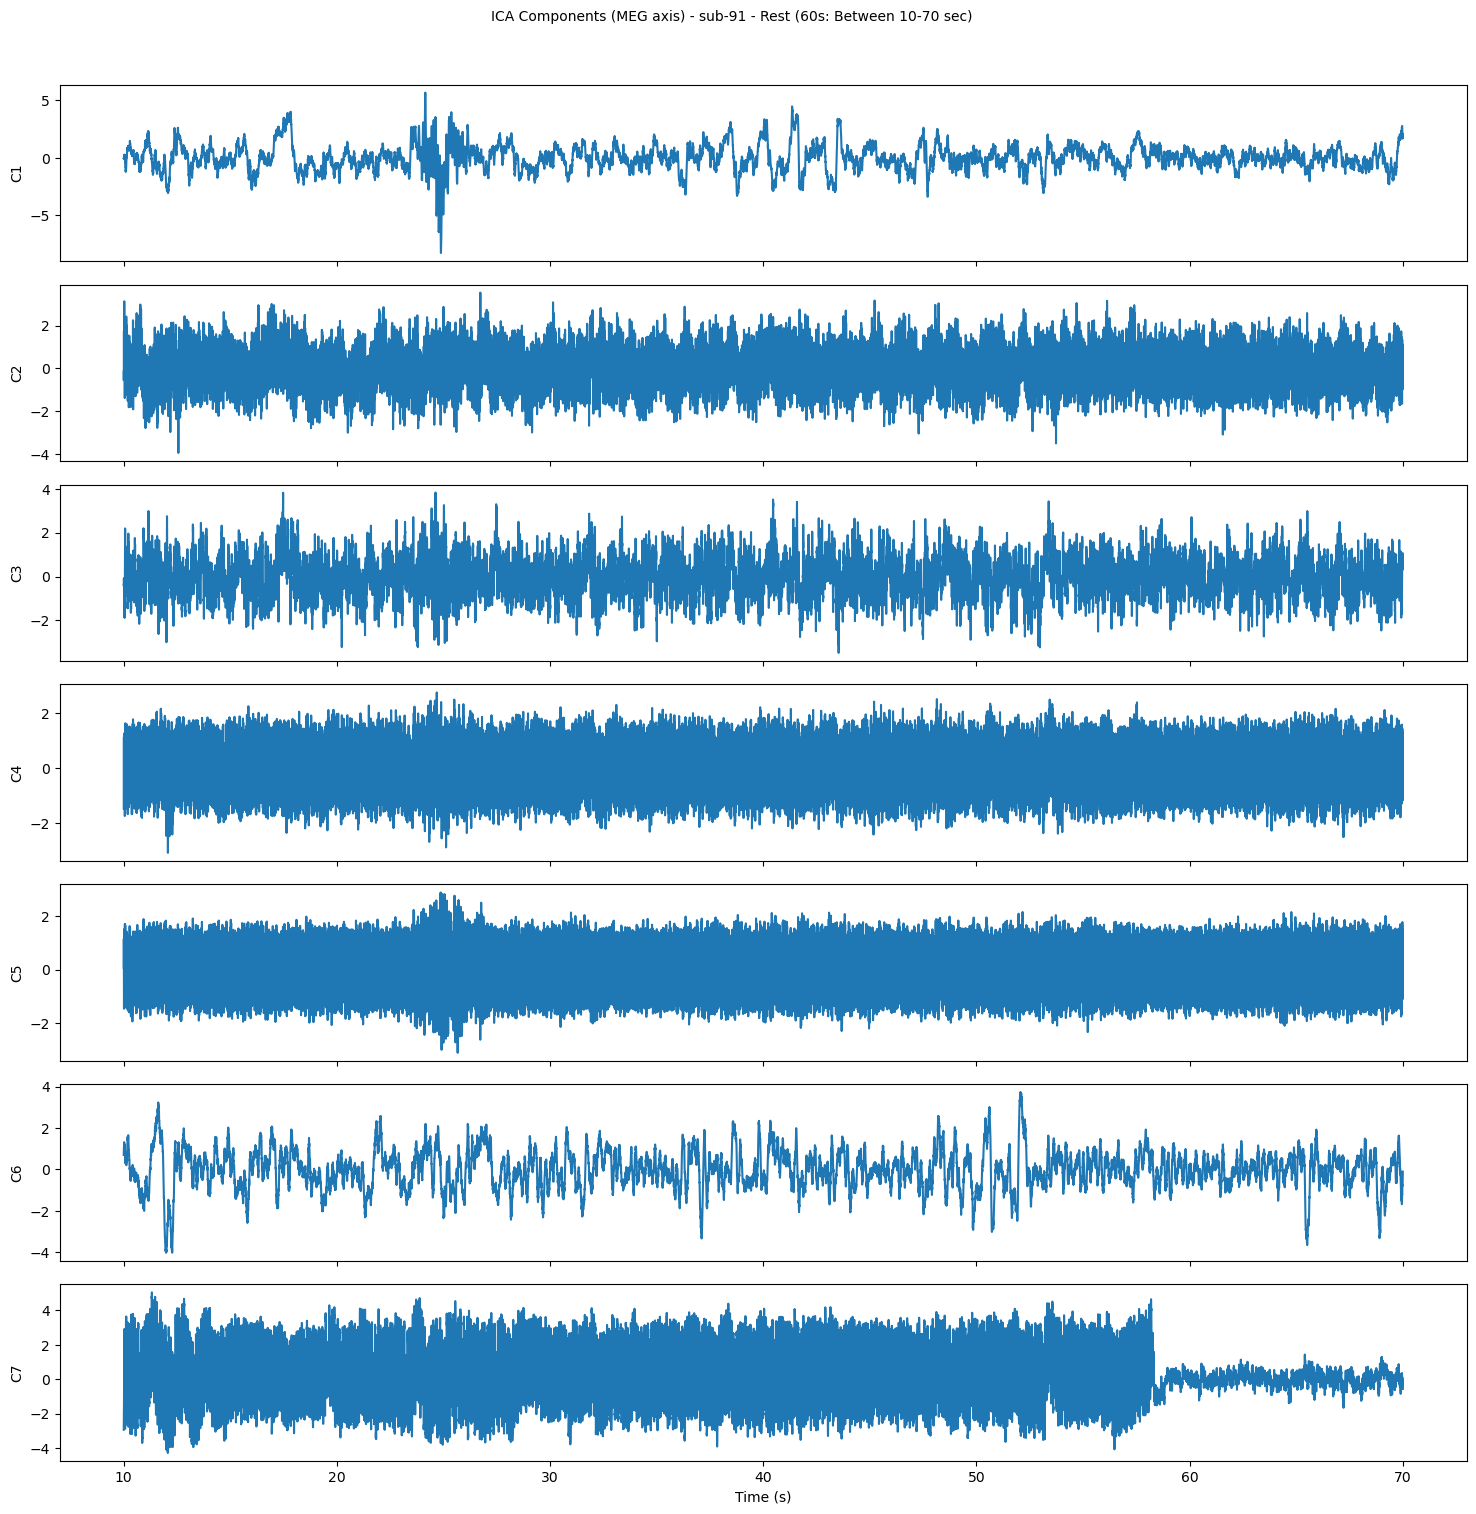


VISUALIZING ICA COMPONENTS - 60 SECOND WINDOW


In [13]:
# ---- VISUALIZE ICA COMPONENTS (60-SECOND WINDOW) ----


# Define ICA visualization window
ICA_WINDOW_DURATION = 60  # sec
ICA_START_TIME = 10       

# Create mask for ICA window
ica_mask = (PREPROCESSED_TIME >= ICA_START_TIME) & (PREPROCESSED_TIME <= ICA_START_TIME + ICA_WINDOW_DURATION)

# Extract windowed data
ica_time_window = PREPROCESSED_TIME[ica_mask]
ica_signals_window = ica_signals[:, ica_mask]

plot_ica_components(
    ica_signals=ica_signals_window,
    time=ica_time_window,
    axis_label="MEG",
    rec_label=f"{SUBJECT_ID} - {CONDITION} ({ICA_WINDOW_DURATION}s: Between {ICA_START_TIME}-{ICA_START_TIME + ICA_WINDOW_DURATION} sec)",
)

print("\n" + "="*60)
print(f"VISUALIZING ICA COMPONENTS - {ICA_WINDOW_DURATION} SECOND WINDOW")
print("="*60)

### 2.4- Select the artifacts:

-**Choose which ICA components you want to remove.**

In [14]:
# ---- USER CONFIGURATION: ARTIFACT COMPONENTS TO REMOVE ----
print("\n" + "="*60)
print("ICA ARTIFACT REMOVAL CONFIGURATION")
print("="*60)

# USER DEFINES WHICH COMPONENTS ARE ARTIFACTS (1-based: ICA-1, ICA-2, etc.)
ARTIFACT_COMPONENTS = [3, 6]  # Example: Remove ICA-3 and ICA-6

# Remove artifacts from preprocessed data
cleaned_meg_channels = remove_ica_artifacts(
    preprocessed_channels=preprocessed_meg_channels,
    ica_signals=ica_signals,
    ica_model=ica_model,
    artifact_components=ARTIFACT_COMPONENTS,
    verbose=True
)



ICA ARTIFACT REMOVAL CONFIGURATION
 ICA-3 removed
 ICA-6 removed



POWER SPECTRUM ANALYSIS: CLEANED MEG CHANNELS
Analyzing 7 cleaned MEG channels
Sampling frequency: 512 Hz


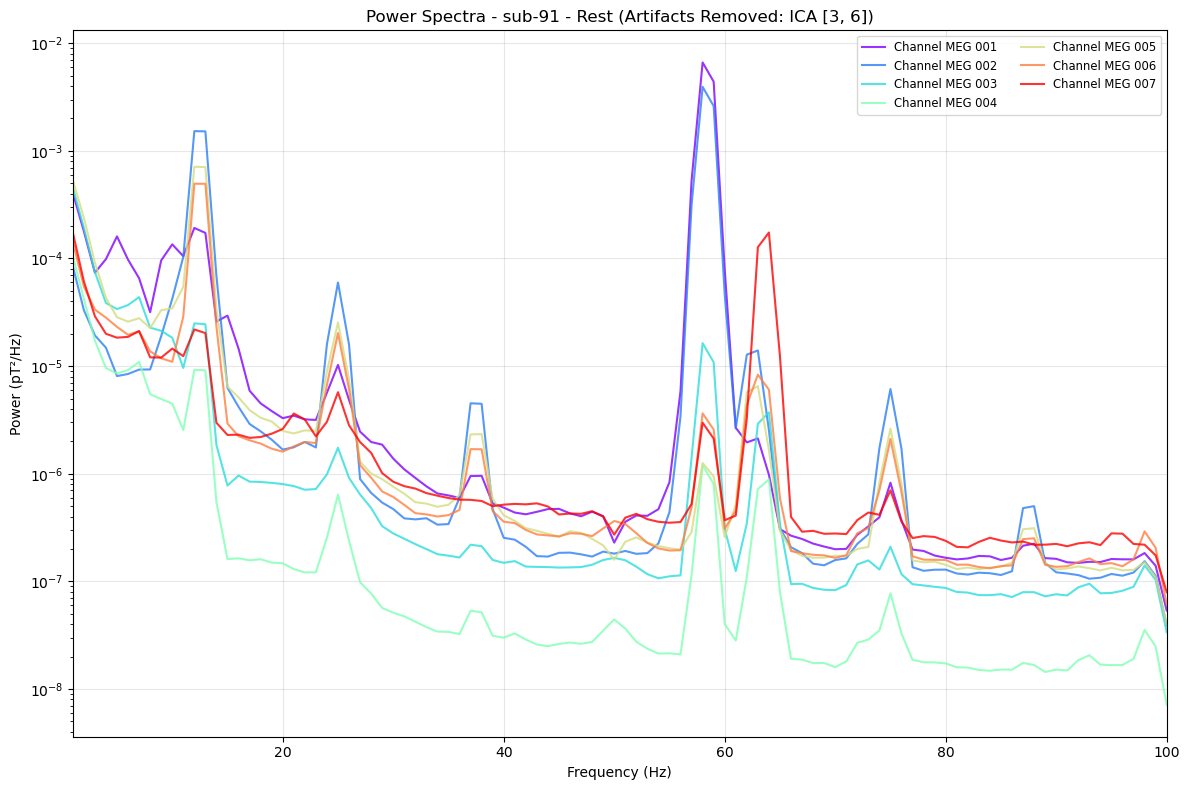

In [15]:
# ---- VISUALIZE CLEANED DATA POWER SPECTRA ----
print("\n" + "="*60)
print("POWER SPECTRUM ANALYSIS: CLEANED MEG CHANNELS")
print("="*60)

print(f"Analyzing {len(cleaned_meg_channels)} cleaned MEG channels")
print(f"Sampling frequency: {TARGET_SFREQ} Hz")

plot_all_channel_power_spectra(
    channels=cleaned_meg_channels,
    channel_names=MEG_CHANNEL_NAMES,
    title=f"{SUBJECT_ID} - {CONDITION} (Artifacts Removed: ICA {ARTIFACT_COMPONENTS})",
    sfreq=TARGET_SFREQ,
    window_length=1.0,
    overlap=0.5,
    freq_range=(1, 100)
)